In [1]:
import torch
import random
import pandas as pd
import torch_scatter
import torch.nn as nn
from torch.nn import Linear, Sequential, LayerNorm, ReLU
import torch.optim as optim
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.data import DataLoader
from torch_geometric.data import Dataset, Data
from torch_geometric.utils import get_laplacian

import numpy as np
import pickle
import time
from tqdm import trange
import copy
import os
import matplotlib.pyplot as plt
import scipy.io as sio

In [2]:
#Define the list that will return the data graphs
spt_data_list = []
spc_data_list = []

number_trajectories = 50
number_ts = 11
var_noise = 0.000
num_eig = 3

In [4]:
with open("data_train2.pkl",'rb') as file:
    data = pickle.load(file)

    for i, trajectory in enumerate(data.keys()):
        if(i==number_trajectories):
            break
        print("Trajectory: ",i)

        #We iterate over all the time steps to produce an example graph except
        #for the last one, which does not have a following time step to produce
        #node output values
        for ts in range(len(data[trajectory]['current_node_pos'])-1):

            if(ts==number_ts):
                break

            #Get node features
            ref_node_pos = torch.from_numpy(data[trajectory]['ref_node_pos'][ts])
            current_node_pos = torch.from_numpy(data[trajectory]['current_node_pos'][ts])
            del_ext_force = torch.from_numpy(data[trajectory]["del_ext_force"][ts])
            node_type_idx = data[trajectory]['node_types'][ts]
            # convert to one hot tensor form
            node_type = torch.zeros(node_type_idx.shape[0], np.unique(node_type_idx).shape[0])
            for j in range(node_type_idx.shape[0]):
                node_type[j, node_type_idx[j, 0]] = 1
            
            stress = torch.from_numpy(data[trajectory]['stress'][ts])
            stress = stress + (var_noise**0.5)*torch.randn(stress.shape)
            # x = torch.cat((ref_node_pos, current_node_pos, del_ext_force, node_type), dim=-1).type(torch.float)
            x = torch.cat((stress, node_type), dim=-1).type(torch.float)
            # x = node_type.type(torch.float)
            n_nodes = torch.tensor([[x.shape[0]]])

            edge_index = torch.from_numpy(data[trajectory]['edge_index'][ts]).type(torch.long)

            #Get edge features (mesh space as well as current configuration)
            uR_i = torch.from_numpy(data[trajectory]['ref_node_pos'][ts])[edge_index[0]]
            uR_j = torch.from_numpy(data[trajectory]['ref_node_pos'][ts])[edge_index[1]]
            uR_ij = uR_i-uR_j
            uR_ij = uR_ij + (var_noise**0.5)*torch.randn(uR_ij.shape)
            uR_ij_norm = torch.norm(uR_ij, p=2, dim=1, keepdim=True)
            uC_i = torch.from_numpy(data[trajectory]['current_node_pos'][ts])[edge_index[0]]
            uC_j = torch.from_numpy(data[trajectory]['current_node_pos'][ts])[edge_index[1]]
            uC_ij = uC_i-uC_j
            uC_ij = uC_ij + (var_noise**0.5)*torch.randn(uC_ij.shape)
            uC_ij_norm = torch.norm(uC_ij, p=2, dim=1, keepdim=True)

            edge_attr = torch.cat((uR_ij, uR_ij_norm), dim=-1).type(torch.float)  #, uC_ij, uC_ij_norm

            del_ext_force = del_ext_force #+ (var_noise**0.5)*torch.randn(del_ext_force.shape)
            del_ext_force = del_ext_force.type(torch.float)

            #Node outputs, for training
            del_displacement = torch.from_numpy(data[trajectory]['current_node_pos'][ts+1]-data[trajectory]['current_node_pos'][ts])
            # y = del_displacement.type(torch.float)
            stress_next = torch.from_numpy(data[trajectory]['stress'][ts+1])
            y = torch.cat((del_displacement, stress_next), dim=-1).type(torch.float)

            #Node outputs, for testing
            strain_energy = torch.from_numpy(data[trajectory]['strain_energy'][ts])

            #Data needed for visualization code
            current_node_pos = torch.from_numpy(data[trajectory]['current_node_pos'][ts])

            # spectral graph information
            ed_idx, ed_w = get_laplacian(edge_index)
            lap = torch.sparse_coo_tensor(ed_idx, ed_w, (x.shape[0], x.shape[0]))
            lap = lap.to_dense()
            E, V = torch.linalg.eigh(lap)
            idx_st = 0
            E = E[idx_st:idx_st+num_eig]
            V = V[:, idx_st:idx_st+num_eig]
            V = V/torch.sqrt(torch.sum(V**2, axis=0))

            spx = E.reshape(-1, 1)
            sp_edge_index_init = torch.ones(num_eig, num_eig) - torch.eye(num_eig)
            sp_edge_index_init = sp_edge_index_init.to_sparse()
            sp_edge_index = sp_edge_index_init.indices()
            sp_edge_attr = torch.ones((sp_edge_index.shape[1], 1), dtype = torch.float)

            spt_data_list.append(Data(x = x, edge_index = edge_index, edge_attr = edge_attr, del_ext_force = del_ext_force, y = y,
                                  stress = stress, strain_energy = strain_energy, current_node_pos = current_node_pos))

            spc_data_list.append(Data(x = spx, edge_index = sp_edge_index, edge_attr = sp_edge_attr, V = V, n_nodes = n_nodes))

    

data_list = {"spt_data_list": spt_data_list, 
                "spc_data_list": spc_data_list}

print("data_list length: ", len(data_list))
print("Done collecting data!")

torch.save(data_list, 'processed_train_set.pt')
print("Done saving data!")

#os.path.join(data_folder + '/test.h5')
#torch.save(data_list,'./'+dataset_dir+'/test_processed_set.pt')

# print("Output Location: ", dataset_dir+'/test_processed_set.pt')

Trajectory:  0
Trajectory:  1
Trajectory:  2
Trajectory:  3
Trajectory:  4
Trajectory:  5
Trajectory:  6
Trajectory:  7
Trajectory:  8
Trajectory:  9
Trajectory:  10
Trajectory:  11
Trajectory:  12
Trajectory:  13
Trajectory:  14
Trajectory:  15
Trajectory:  16
Trajectory:  17
Trajectory:  18
Trajectory:  19
Trajectory:  20
Trajectory:  21
Trajectory:  22
Trajectory:  23
Trajectory:  24
Trajectory:  25
Trajectory:  26
Trajectory:  27
Trajectory:  28
Trajectory:  29
Trajectory:  30
Trajectory:  31
Trajectory:  32
Trajectory:  33
Trajectory:  34
Trajectory:  35
Trajectory:  36
Trajectory:  37
Trajectory:  38
Trajectory:  39
Trajectory:  40
Trajectory:  41
Trajectory:  42
Trajectory:  43
Trajectory:  44
Trajectory:  45
Trajectory:  46
Trajectory:  47
Trajectory:  48
Trajectory:  49
data_list length:  2
Done collecting data!
Done saving data!


In [4]:
sp_edge_index

tensor([[0, 0, 1, 1, 2, 2],
        [1, 2, 0, 2, 0, 1]])

In [5]:
dataset = torch.load('processed_train_set.pt')
spt_dataset = dataset["spt_data_list"][:512]
spc_dataset = dataset["spc_data_list"][:512]

In [6]:
spt_dataset[0].x #.shape[1:]

tensor([[0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [7]:
# normalization in order to stabilize training
def normalize(to_normalize,mean_vec,std_vec):
    return (to_normalize-mean_vec)/std_vec

def unnormalize(to_unnormalize,mean_vec,std_vec):
    return to_unnormalize*std_vec+mean_vec

def get_stats(data_list):
    '''
    Method for normalizing processed datasets. Given  the processed data_list, 
    calculates the mean and standard deviation for the node features, edge features, 
    and node outputs, and normalizes these using the calculated statistics.
    '''

    #mean and std of the node features are calculated
    mean_vec_x=torch.zeros(data_list[0].x.shape[1:])
    std_vec_x=torch.zeros(data_list[0].x.shape[1:])

    #mean and std of the edge features are calculated
    mean_vec_edge=torch.zeros(data_list[0].edge_attr.shape[1:])
    std_vec_edge=torch.zeros(data_list[0].edge_attr.shape[1:])

    #mean and std of the incremental external force are calculated
    mean_vec_force = torch.zeros(data_list[0].del_ext_force.shape[1:])
    std_vec_force = torch.zeros(data_list[0].del_ext_force.shape[1:])

    #mean and std of the output parameters are calculated
    mean_vec_y=torch.zeros(data_list[0].y.shape[1:])
    std_vec_y=torch.zeros(data_list[0].y.shape[1:])

    #Define the maximum number of accumulations to perform such that we do
    #not encounter memory issues
    max_accumulations = 10**6

    #Define a very small value for normalizing to 
    eps=torch.tensor(np.finfo(float).eps)

    #Define counters used in normalization
    num_accs_x = 0
    num_accs_edge=0
    num_accs_force=0
    num_accs_y=0

    #Iterate through the data in the list to accumulate statistics
    for dp in data_list:

        #Add to the 
        mean_vec_x+=torch.sum(dp.x,dim=0)
        std_vec_x+=torch.sum(dp.x**2,dim=0)
        num_accs_x+=dp.x.shape[0]

        mean_vec_edge+=torch.sum(dp.edge_attr,dim=0)
        std_vec_edge+=torch.sum(dp.edge_attr**2,dim=0)
        num_accs_edge+=dp.edge_attr.shape[0]

        mean_vec_force+=torch.sum(dp.del_ext_force,dim=0)
        std_vec_force+=torch.sum(dp.del_ext_force**2,dim=0)
        num_accs_force+=dp.del_ext_force.shape[0]

        mean_vec_y+=torch.sum(dp.y,dim=0)
        std_vec_y+=torch.sum(dp.y**2,dim=0)
        num_accs_y+=dp.y.shape[0]

        if(num_accs_x>max_accumulations or num_accs_edge>max_accumulations or num_accs_force>max_accumulations or num_accs_y>max_accumulations):
            break

    mean_vec_x = mean_vec_x/num_accs_x
    std_vec_x = torch.maximum(torch.sqrt(std_vec_x/num_accs_x - mean_vec_x**2),eps)

    mean_vec_edge = mean_vec_edge/num_accs_edge
    std_vec_edge = torch.maximum(torch.sqrt(std_vec_edge/num_accs_edge - mean_vec_edge**2),eps)

    mean_vec_force = mean_vec_force/num_accs_force
    std_vec_force = torch.maximum(torch.sqrt(std_vec_force/num_accs_force - mean_vec_force**2),eps)

    mean_vec_y = mean_vec_y/num_accs_y
    std_vec_y = torch.maximum(torch.sqrt(std_vec_y/num_accs_y - mean_vec_y**2),eps)

    mean_std_list=[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_force,std_vec_force,mean_vec_y,std_vec_y]

    return mean_std_list

In [8]:
class MeshGraphNet(torch.nn.Module):
    def __init__(self, input_dim_node, input_dim_edge, sp_input_dim_node, sp_input_dim_edge, 
                    hidden_dim, dim_ext_force, output_dim, args, emb=False):
        super(MeshGraphNet, self).__init__()
        """
        MeshGraphNet model. This model is built upon Deepmind's 2021 paper.
        This model consists of three parts: (1) Preprocessing: encoder (2) Processor
        (3) postproccessing: decoder. Encoder has an edge and node decoders respectively.
        Processor has two processors for edge and node respectively. Note that edge attributes have to be
        updated first. Decoder is only for nodes.

        Input_dim: dynamic variables + node_type + node_position
        Hidden_dim: 128 in deepmind's paper
        Output_dim: dynamic variables: velocity changes (1)

        """

        self.num_layers = args.num_layers

        # encoder convert raw inputs into latent embeddings
        self.node_encoder = Sequential(Linear(input_dim_node , hidden_dim),
                              ReLU(),
                              Linear( hidden_dim, hidden_dim),
                              LayerNorm(hidden_dim))

        self.edge_encoder = Sequential(Linear(input_dim_edge , hidden_dim),
                              ReLU(),
                              Linear( hidden_dim, hidden_dim),
                              LayerNorm(hidden_dim)
                              )

        self.spnode_encoder = Sequential(Linear(sp_input_dim_node , hidden_dim),
                              ReLU(),
                              Linear( hidden_dim, hidden_dim),
                              LayerNorm(hidden_dim))

        self.spedge_encoder = Sequential(Linear(sp_input_dim_edge , hidden_dim),
                              ReLU(),
                              Linear( hidden_dim, hidden_dim),
                              LayerNorm(hidden_dim)
                              )                 


        self.processor = nn.ModuleList()
        self.sp_processor = nn.ModuleList()
        assert (self.num_layers >= 1), 'Number of message passing layers is not >=1'

        processor_layer=self.build_processor_model()
        for _ in range(self.num_layers):
            self.processor.append(processor_layer(hidden_dim, dim_ext_force, hidden_dim))
            self.sp_processor.append(processor_layer(hidden_dim, 0, hidden_dim))


        # decoder: only for node embeddings
        self.decoder = Sequential(Linear( 2*hidden_dim , hidden_dim),
                              ReLU(),
                              Linear( hidden_dim, output_dim)
                              )


    def build_processor_model(self):
        return ProcessorLayer


    def eigenpooling(self, V, x, idx_lim_Gnodes):
        spx_pooled = torch.empty((0, x.shape[1]))

        for ii in range(idx_lim_Gnodes.shape[0]):
            idx1 = idx_lim_Gnodes[ii, 0]
            idx2 = idx_lim_Gnodes[ii, 1]
            spx_pooled_part = torch.matmul(torch.t(V[idx1:idx2, :]),x[idx1:idx2, :])
            spx_pooled = torch.cat((spx_pooled, spx_pooled_part), dim = 0)
        
        return spx_pooled


    def eigenbroadcasting(self, V, spx, idx_lim_Gnodes):
        x_broadcasted = torch.empty((0, spx.shape[1]))
        n_eigmodes  = V.shape[1]

        for ii in range(idx_lim_Gnodes.shape[0]):
            idx1 = idx_lim_Gnodes[ii, 0]
            idx2 = idx_lim_Gnodes[ii, 1]
            x_broadcasted_part = torch.matmul(V[idx1:idx2, :],spx[n_eigmodes*ii:n_eigmodes*(ii+1), :])
            x_broadcasted = torch.cat((x_broadcasted, x_broadcasted_part), dim = 0)
        
        return x_broadcasted


    def forward(self,spt_data,spc_data,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_force,std_vec_force):
        """
        Encoder encodes graph (node/edge features) into latent vectors (node/edge embeddings)
        The return of processor is fed into the processor for generating new feature vectors
        """
        x, edge_index, edge_attr, del_ext_force, stress = spt_data.x, spt_data.edge_index, spt_data.edge_attr, spt_data.del_ext_force, spt_data.stress

        spx, sp_edge_index,  sp_edge_attr, V, n_nodes = spc_data.x, spc_data.edge_index, spc_data.edge_attr, spc_data.V, spc_data.n_nodes

        # print('n_nodes: ',n_nodes)
        # print('x.shape: ', x.shape)
        # print('edge_index.shape: ', edge_index)
        # print('edge_attr.shape: ', edge_attr)
        # print('spx.shape: ', spx.shape)
        # print('sp_edge_index.shape: ', sp_edge_index)
        # print('sp_edge_attr.shape: ', sp_edge_attr)

        n_nodes_cumsum = torch.cumsum(n_nodes.reshape(-1, ), dim=0)
        idx_lim_Gnodes = torch.zeros((n_nodes.shape[0], 2), dtype = torch.int64)
        idx_lim_Gnodes[1:, 0] = n_nodes_cumsum[:-1]
        idx_lim_Gnodes[:, 1] = n_nodes_cumsum
        # print('idx_lim_Gnodes: ', idx_lim_Gnodes)

        x = normalize(x,mean_vec_x,std_vec_x)
        edge_attr=normalize(edge_attr,mean_vec_edge,std_vec_edge)
        del_ext_force = normalize(del_ext_force,mean_vec_force,std_vec_force)

        # Step 1: encode node/edge features into latent node/edge embeddings
        x = self.node_encoder(x) # output shape is the specified hidden dimension
        edge_attr = self.edge_encoder(edge_attr) # output shape is the specified hidden dimension

        spx = self.spnode_encoder(spx)
        sp_edge_attr = self.spedge_encoder(sp_edge_attr)

        x_new = torch.cat((x, self.eigenbroadcasting(V, spx, idx_lim_Gnodes)), dim = 1)
        spx = torch.cat((spx, self.eigenpooling(V, x, idx_lim_Gnodes)), dim = 1)
        x = x_new

        # step 2: perform message passing with latent node/edge embeddings
        for i in range(self.num_layers):
            x_i, edge_attr = self.processor[i](x,edge_index,edge_attr,del_ext_force)
            spx_i, sp_edge_attr = self.sp_processor[i](spx,sp_edge_index,sp_edge_attr,del_ext_force = None)

            x = x[:, 0:x_i.shape[1]]
            spx = spx[:, 0:x_i.shape[1]]
            x_new = torch.cat((x_i, self.eigenbroadcasting(V, spx, idx_lim_Gnodes)), dim = 1)
            spx = torch.cat((spx_i, self.eigenpooling(V, x, idx_lim_Gnodes)), dim = 1)
            x = x_new
            # print('x.shape: ', x.shape)
            # print('spx.shape: ', spx.shape)

        # step 3: decode latent node embeddings into physical quantities of interest

        return self.decoder(x)

    def loss(self, pred, inputs, mean_vec_y, std_vec_y):
        #Define the node types that we calculate loss for
        normal=torch.tensor(0)
        outflow=torch.tensor(5)

        #Get the loss mask for the nodes of the types we calculate loss for
        loss_mask=torch.logical_or((torch.argmax(inputs.x[:,1:],dim=1)==torch.tensor(1)),
                                   (torch.argmax(inputs.x[:,1:],dim=1)==torch.tensor(2)))
        # print('loss_mask', loss_mask)

        #Normalize labels with dataset statistics
        labels = normalize(inputs.y, mean_vec_y, std_vec_y)

        #Find sum of square errors
        error=torch.sum((labels-pred)**2,axis=1)

        #Root and mean the errors for the nodes we calculate loss for
        loss= torch.sqrt(torch.mean(error))            #torch.sqrt(torch.mean(error[loss_mask]))
        
        return loss

In [9]:
class ProcessorLayer(MessagePassing):
    def __init__(self, in_channels, dim_ext_force, out_channels,  **kwargs):
        super(ProcessorLayer, self).__init__(  **kwargs )
        """
        in_channels: dim of node embeddings [128], out_channels: dim of edge embeddings [128]

        """

        # Note that the node and edge encoders both have the same hidden dimension
        # size. This means that the input of the edge processor will always be
        # three times the specified hidden dimension
        # (input: adjacent node embeddings and self embeddings)
        self.edge_mlp = Sequential(Linear( 5* in_channels , out_channels),
                                   ReLU(),
                                   Linear( out_channels, out_channels),
                                   LayerNorm(out_channels))

        self.node_mlp = Sequential(Linear( 3* in_channels + dim_ext_force , out_channels),
                                   ReLU(),
                                   Linear( out_channels, out_channels),
                                   LayerNorm(out_channels))


        self.reset_parameters()

    def reset_parameters(self):
        """
        reset parameters for stacked MLP layers
        """
        self.edge_mlp[0].reset_parameters()
        self.edge_mlp[2].reset_parameters()

        self.node_mlp[0].reset_parameters()
        self.node_mlp[2].reset_parameters()

    def forward(self, x, edge_index, edge_attr, del_ext_force, size = None):
        """
        Handle the pre and post-processing of node features/embeddings,
        as well as initiates message passing by calling the propagate function.

        Note that message passing and aggregation are handled by the propagate
        function, and the update

        x has shpae [node_num , in_channels] (node embeddings)
        edge_index: [2, edge_num]
        edge_attr: [E, in_channels]

        """

        out, updated_edges = self.propagate(edge_index, x = x, edge_attr = edge_attr, size = size) # out has the shape of [E, out_channels]

        if del_ext_force == None:
            updated_nodes = torch.cat([x,out],dim=1)
        else:
            updated_nodes = torch.cat([x,out,del_ext_force],dim=1)        # Complete the aggregation through self-aggregation

        updated_nodes = self.node_mlp(updated_nodes) # residual connection
        updated_nodes = x[:, 0:updated_nodes.shape[1]] + updated_nodes # residual connection

        return updated_nodes, updated_edges

    def message(self, x_i, x_j, edge_attr):
        """
        source_node: x_i has the shape of [E, in_channels]
        target_node: x_j has the shape of [E, in_channels]
        target_edge: edge_attr has the shape of [E, out_channels]

        The messages that are passed are the raw embeddings. These are not processed.
        """

        updated_edges=torch.cat([x_i, x_j, edge_attr], dim = 1) # tmp_emb has the shape of [E, 3 * in_channels]
        updated_edges=self.edge_mlp(updated_edges)+edge_attr

        return updated_edges

    def aggregate(self, updated_edges, edge_index, dim_size = None):
        """
        First we aggregate from neighbors (i.e., adjacent nodes) through concatenation,
        then we aggregate self message (from the edge itself). This is streamlined
        into one operation here.
        """

        # The axis along which to index number of nodes.
        node_dim = 0

        out = torch_scatter.scatter(updated_edges, edge_index[0, :], dim=node_dim, reduce = 'sum')

        return out, updated_edges

In [10]:
def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

In [11]:
def train(spt_dataset, spc_dataset, device, stats_list, args):
    '''
    Performs a training loop on the dataset for MeshGraphNets. Also calls
    test and validation functions.
    '''

    df = pd.DataFrame(columns=['epoch','train_loss','test_loss', 'velo_val_loss'])

    #Define the model name for saving 
    model_name='model_spectralGNN_w_X_StressType_nl'+str(args.num_layers)+'_bs'+str(args.batch_size) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.epochs)+'_wd'+str(args.weight_decay) + \
               '_lr'+str(args.lr)+'_shuff_'+str(args.shuffle)+'_tr'+str(args.train_size)+'_te'+str(args.test_size)

    #torch_geometric DataLoaders are used for handling the data of lists of graphs
    spt_loader = DataLoader(spt_dataset[:args.train_size], batch_size=args.batch_size, shuffle=False)
    spt_test_loader = DataLoader(spt_dataset[args.train_size:], batch_size=args.batch_size, shuffle=False)
    spc_loader = DataLoader(spc_dataset[:args.train_size], batch_size=args.batch_size, shuffle=False)
    spc_test_loader = DataLoader(spc_dataset[args.train_size:], batch_size=args.batch_size, shuffle=False)

    #The statistics of the data are decomposed
    [mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_force,std_vec_force,mean_vec_y,std_vec_y] = stats_list
    (mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_force,std_vec_force,mean_vec_y,std_vec_y)=(mean_vec_x.to(device),
        std_vec_x.to(device),mean_vec_edge.to(device),std_vec_edge.to(device),mean_vec_force.to(device),std_vec_force.to(device),
        mean_vec_y.to(device),std_vec_y.to(device))

    # build model
    num_node_features = spt_dataset[0].x.shape[1]
    num_edge_features = spt_dataset[0].edge_attr.shape[1]
    num_ext_force = spt_dataset[0].del_ext_force.shape[1]
    num_sp_node_features = spc_dataset[0].x.shape[1]
    num_sp_edge_features = spc_dataset[0].edge_attr.shape[1]
    num_classes = 1 # the dynamic variables have the shape of 1 (displacement)


    model = MeshGraphNet(num_node_features, num_edge_features, num_sp_node_features, num_sp_edge_features, 
                            args.hidden_dim, num_ext_force, num_classes, args).to(device)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_losses = []
    disp_val_losses = []
    best_test_loss = np.inf
    best_model = None
    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        model.train()
        num_loops=0
        for (spt_batch, spc_batch) in zip(spt_loader, spc_loader):
            #Note that normalization must be done before it's called. The unnormalized
            #data needs to be preserved in order to correctly calculate the loss
            spt_batch=spt_batch.to(device)
            spc_batch=spc_batch.to(device)
            opt.zero_grad()         #zero gradients each time
            pred = model(spt_batch,spc_batch,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_force,std_vec_force)
            loss = model.loss(pred,spt_batch,mean_vec_y,std_vec_y)
            loss.backward()         #backpropagate loss
            opt.step()
            total_loss += loss.item()
            num_loops+=1
        total_loss /= num_loops
        losses.append(total_loss)

        #Every tenth epoch, calculate acceleration test loss and velocity validation loss
        if epoch % 10 == 0:
            if (args.save_disp_val):
                # save velocity evaluation
                test_loss, disp_val_rmse = test(spt_test_loader,spc_test_loader,device,model,mean_vec_x,std_vec_x,mean_vec_edge,
                                 std_vec_edge,mean_vec_force,std_vec_force,mean_vec_y,std_vec_y, args.save_disp_val)
                disp_val_losses.append(disp_val_rmse.item())
            else:
                test_loss, _ = test(spt_test_loader,spc_test_loader,device,model,mean_vec_x,std_vec_x,mean_vec_edge,
                                 std_vec_edge,mean_vec_force,std_vec_force,mean_vec_y,std_vec_y, args.save_disp_val)

            test_losses.append(test_loss.item())

            # saving model
            if not os.path.isdir( args.checkpoint_dir ):
                os.mkdir(args.checkpoint_dir)

            PATH = os.path.join(args.checkpoint_dir, model_name+'.csv')
            df.to_csv(PATH,index=False)

            #save the model if the current one is better than the previous best
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_model = copy.deepcopy(model)

        else:
            #If not the tenth epoch, append the previously calculated loss to the
            #list in order to be able to plot it on the same plot as the training losses
            if (args.save_disp_val):
              test_losses.append(test_losses[-1])
              disp_val_losses.append(disp_val_losses[-1])

        if (args.save_disp_val):
            df = df.append({'epoch': epoch,'train_loss': losses[-1],
                            'test_loss':test_losses[-1],
                           'velo_val_loss': disp_val_losses[-1]}, ignore_index=True)
        else:
            df = df.append({'epoch': epoch, 'train_loss': losses[-1], 'test_loss': test_losses[-1]}, ignore_index=True)
        if(epoch%100==0):
            if (args.save_disp_val):
                print("train loss: ", str(round(total_loss, 2)),
                      "| test loss: ", str(round(test_loss.item(), 2)),
                      "| velo loss: ", str(round(disp_val_rmse.item(), 5)))
            else:
                print("train loss: ", str(round(total_loss,2)), "| test loss: ", str(round(test_loss.item(),2)))


            if(args.save_best_model):

                PATH = os.path.join(args.checkpoint_dir, model_name+'.pt')
                torch.save(best_model.state_dict(), PATH )

    return test_losses, losses, disp_val_losses, best_model, best_test_loss




    

def test(spt_loader,spc_loader,device,test_model,
         mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_force,std_vec_force,mean_vec_y,std_vec_y, is_validation,
          delta_t=0.01, save_model_preds=False, model_type=None):
  
    '''
    Calculates test set losses and validation set errors.
    '''

    loss=0
    disp_rmse = 0
    num_loops=0

    for (spt_data, spc_data) in zip(spt_loader, spc_loader):
        spt_data=spt_data.to(device)
        spc_data=spc_data.to(device)
        with torch.no_grad():

            #calculate the loss for the model given the test set
            pred = test_model(spt_data, spc_data, mean_vec_x, std_vec_x, mean_vec_edge, std_vec_edge, mean_vec_force, std_vec_force)
            loss += test_model.loss(pred, spt_data, mean_vec_y, std_vec_y)

            #calculate validation error if asked to
            if (is_validation):

                #Like for the MeshGraphNets model, calculate the mask over which we calculate
                #flow loss and add this calculated RMSE value to our val error
                normal = torch.tensor(0)
                outflow = torch.tensor(5)
                loss_mask = torch.logical_or((torch.argmax(spt_data.x[:, 1:], dim=1) == torch.tensor(1)),
                                             (torch.argmax(spt_data.x[:, 1:], dim=1) == torch.tensor(2)))

                eval_disp = unnormalize( pred[:], mean_vec_y, std_vec_y )
                
                error = torch.sum((eval_disp - spt_data.y[:]) ** 2, axis=1)
                disp_rmse += torch.sqrt(torch.mean(error)) #torch.sqrt(torch.mean(error[loss_mask]))

        num_loops+=1
        # print('num_loops: ', num_loops)
        # if velocity is evaluated, return velo_rmse as 0
    return loss/num_loops, disp_rmse/num_loops

In [22]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

for args in [
        {'model_type': 'meshgraphnet',  
         'num_layers': 5,
         'batch_size': 32, 
         'hidden_dim': 8, 
         'epochs': 10000,
         'opt': 'adam', 
         'opt_scheduler': 'none', 
         'opt_restart': 0, 
         'weight_decay': 5e-4, 
         'lr': 0.001,
         'train_size': 448, 
         'test_size': 64, 
         'device':'cuda',
         'shuffle': True, 
         'save_disp_val': True,
         'save_best_model': True, 
         'checkpoint_dir': './best_models/',
         'postprocess_dir': './2d_loss_plots/'},
    ]:
        args = objectview(args)

#To ensure reproducibility the best we can, here we control the sources of
#randomness by seeding the various random number generators used in this Colab
#For more information, see: https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(5)  #Torch
random.seed(5)        #Python
np.random.seed(5)     #NumPy

In [23]:
if(args.shuffle):
  spt_dataset_shuf = []
  spc_dataset_shuf = []
  idx_shuf = list(range(len(spt_dataset)))
  random.shuffle(idx_shuf)
  for i in idx_shuf:
    spt_dataset_shuf.append(spt_dataset[i])
    spc_dataset_shuf.append(spc_dataset[i])
  spt_dataset = spt_dataset_shuf
  spc_dataset = spc_dataset_shuf

stats_list = get_stats(spt_dataset)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.device = device
print(device)

cpu


In [24]:
spt_dataset[0]

Data(x=[6, 4], edge_index=[2, 10], edge_attr=[10, 2], y=[6, 1], del_ext_force=[6, 1], stress=[6, 1], strain_energy=[1], current_node_pos=[6, 1])

In [25]:
test_losses, losses, disp_val_losses, best_model, best_test_loss = train(spt_dataset, spc_dataset, device, stats_list, args)

print("Min test set loss: {0}".format(min(test_losses)))
print("Minimum loss: {0}".format(min(losses)))
if (args.save_disp_val):
    print("Minimum displacement validation loss: {0}".format(min(disp_val_losses)))

c:\Users\mmanav\Anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training:   0%|          | 1/10000 [00:01<3:05:53,  1.12s/Epochs]

train loss:  1.0 | test loss:  0.93 | velo loss:  0.00541


Training:   1%|          | 101/10000 [01:24<2:22:45,  1.16Epochs/s]

train loss:  0.08 | test loss:  0.12 | velo loss:  0.00069


Training:   2%|▏         | 201/10000 [02:47<2:21:15,  1.16Epochs/s]

train loss:  0.05 | test loss:  0.1 | velo loss:  0.0006


Training:   3%|▎         | 301/10000 [04:11<2:19:46,  1.16Epochs/s]

train loss:  0.1 | test loss:  0.14 | velo loss:  0.00084


Training:   4%|▍         | 401/10000 [05:35<2:14:58,  1.19Epochs/s]

train loss:  0.08 | test loss:  0.1 | velo loss:  0.00057


Training:   5%|▌         | 501/10000 [06:59<2:12:31,  1.19Epochs/s]

train loss:  0.04 | test loss:  0.06 | velo loss:  0.00035


Training:   6%|▌         | 601/10000 [08:23<2:12:57,  1.18Epochs/s]

train loss:  0.05 | test loss:  0.09 | velo loss:  0.00054


Training:   7%|▋         | 701/10000 [09:47<2:15:11,  1.15Epochs/s]

train loss:  0.04 | test loss:  0.06 | velo loss:  0.00037


Training:   8%|▊         | 801/10000 [11:12<2:12:15,  1.16Epochs/s]

train loss:  0.09 | test loss:  0.09 | velo loss:  0.00052


Training:   9%|▉         | 901/10000 [12:37<2:10:27,  1.16Epochs/s]

train loss:  0.03 | test loss:  0.06 | velo loss:  0.00034


Training:  10%|█         | 1001/10000 [14:00<2:09:13,  1.16Epochs/s]

train loss:  0.05 | test loss:  0.07 | velo loss:  0.00044


Training:  11%|█         | 1101/10000 [15:24<2:07:42,  1.16Epochs/s]

train loss:  0.03 | test loss:  0.05 | velo loss:  0.00029


Training:  12%|█▏        | 1201/10000 [16:48<2:08:22,  1.14Epochs/s]

train loss:  0.03 | test loss:  0.05 | velo loss:  0.0003


Training:  13%|█▎        | 1301/10000 [18:12<2:08:15,  1.13Epochs/s]

train loss:  0.04 | test loss:  0.05 | velo loss:  0.00029


Training:  14%|█▍        | 1401/10000 [19:37<2:12:51,  1.08Epochs/s]

train loss:  0.07 | test loss:  0.08 | velo loss:  0.0005


Training:  15%|█▌        | 1501/10000 [21:01<1:56:19,  1.22Epochs/s]

train loss:  0.03 | test loss:  0.04 | velo loss:  0.00025


Training:  16%|█▌        | 1601/10000 [22:29<2:00:59,  1.16Epochs/s]

train loss:  0.03 | test loss:  0.05 | velo loss:  0.00027


Training:  17%|█▋        | 1701/10000 [23:55<2:00:24,  1.15Epochs/s]

train loss:  0.03 | test loss:  0.05 | velo loss:  0.00028


Training:  18%|█▊        | 1801/10000 [25:24<2:04:45,  1.10Epochs/s]

train loss:  0.03 | test loss:  0.05 | velo loss:  0.00028


Training:  19%|█▉        | 1901/10000 [26:53<1:57:12,  1.15Epochs/s]

train loss:  0.06 | test loss:  0.05 | velo loss:  0.00031


Training:  20%|██        | 2001/10000 [28:17<1:57:00,  1.14Epochs/s]

train loss:  0.03 | test loss:  0.04 | velo loss:  0.00024


Training:  21%|██        | 2101/10000 [29:42<1:53:17,  1.16Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00019


Training:  22%|██▏       | 2201/10000 [31:05<1:49:49,  1.18Epochs/s]

train loss:  0.03 | test loss:  0.04 | velo loss:  0.00024


Training:  23%|██▎       | 2301/10000 [32:30<1:50:39,  1.16Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00019


Training:  24%|██▍       | 2401/10000 [33:54<1:46:40,  1.19Epochs/s]

train loss:  0.03 | test loss:  0.04 | velo loss:  0.00022


Training:  25%|██▌       | 2501/10000 [35:18<1:46:34,  1.17Epochs/s]

train loss:  0.02 | test loss:  0.04 | velo loss:  0.00021


Training:  26%|██▌       | 2601/10000 [36:45<1:45:55,  1.16Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00018


Training:  27%|██▋       | 2701/10000 [38:08<1:44:53,  1.16Epochs/s]

train loss:  0.02 | test loss:  0.05 | velo loss:  0.00028


Training:  28%|██▊       | 2801/10000 [39:32<1:45:10,  1.14Epochs/s]

train loss:  0.02 | test loss:  0.04 | velo loss:  0.00025


Training:  29%|██▉       | 2901/10000 [40:52<1:33:45,  1.26Epochs/s]

train loss:  0.02 | test loss:  0.04 | velo loss:  0.00024


Training:  30%|███       | 3001/10000 [42:09<1:37:04,  1.20Epochs/s]

train loss:  0.02 | test loss:  0.04 | velo loss:  0.00021


Training:  31%|███       | 3101/10000 [43:27<1:32:08,  1.25Epochs/s]

train loss:  0.02 | test loss:  0.04 | velo loss:  0.00021


Training:  32%|███▏      | 3201/10000 [44:45<1:29:24,  1.27Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.0002


Training:  33%|███▎      | 3301/10000 [46:02<1:26:25,  1.29Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.0002


Training:  34%|███▍      | 3401/10000 [47:18<1:27:29,  1.26Epochs/s]

train loss:  0.02 | test loss:  0.04 | velo loss:  0.00021


Training:  35%|███▌      | 3501/10000 [48:36<1:25:06,  1.27Epochs/s]

train loss:  0.02 | test loss:  0.04 | velo loss:  0.00025


Training:  36%|███▌      | 3601/10000 [49:53<1:29:52,  1.19Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.0002


Training:  37%|███▋      | 3701/10000 [51:10<1:23:56,  1.25Epochs/s]

train loss:  0.03 | test loss:  0.04 | velo loss:  0.00024


Training:  38%|███▊      | 3801/10000 [52:28<1:23:42,  1.23Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00019


Training:  39%|███▉      | 3901/10000 [53:45<1:21:12,  1.25Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00018


Training:  40%|████      | 4001/10000 [55:05<1:20:14,  1.25Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00017


Training:  41%|████      | 4101/10000 [56:24<1:19:53,  1.23Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.0002


Training:  42%|████▏     | 4201/10000 [57:43<1:16:11,  1.27Epochs/s]

train loss:  0.04 | test loss:  0.05 | velo loss:  0.00028


Training:  43%|████▎     | 4301/10000 [59:01<1:15:41,  1.25Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00018


Training:  44%|████▍     | 4401/10000 [1:00:20<1:16:08,  1.23Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00018


Training:  45%|████▌     | 4501/10000 [1:01:39<1:16:24,  1.20Epochs/s]

train loss:  0.03 | test loss:  0.04 | velo loss:  0.00021


Training:  46%|████▌     | 4601/10000 [1:02:57<1:11:57,  1.25Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00019


Training:  47%|████▋     | 4701/10000 [1:04:15<1:11:52,  1.23Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00018


Training:  48%|████▊     | 4801/10000 [1:05:34<1:12:14,  1.20Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00019


Training:  49%|████▉     | 4901/10000 [1:06:52<1:10:07,  1.21Epochs/s]

train loss:  0.03 | test loss:  0.03 | velo loss:  0.00019


Training:  50%|█████     | 5001/10000 [1:08:10<1:07:39,  1.23Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00017


Training:  51%|█████     | 5101/10000 [1:09:28<1:06:04,  1.24Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.0002


Training:  52%|█████▏    | 5201/10000 [1:10:46<1:05:09,  1.23Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00019


Training:  53%|█████▎    | 5301/10000 [1:12:04<1:04:55,  1.21Epochs/s]

train loss:  0.03 | test loss:  0.04 | velo loss:  0.00026


Training:  54%|█████▍    | 5401/10000 [1:13:24<1:02:00,  1.24Epochs/s]

train loss:  0.02 | test loss:  0.04 | velo loss:  0.00021


Training:  55%|█████▌    | 5501/10000 [1:14:43<1:01:18,  1.22Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00018


Training:  56%|█████▌    | 5601/10000 [1:16:02<59:41,  1.23Epochs/s]  

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00018


Training:  57%|█████▋    | 5701/10000 [1:17:21<1:00:46,  1.18Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.0002


Training:  58%|█████▊    | 5801/10000 [1:18:40<56:37,  1.24Epochs/s]  

train loss:  0.02 | test loss:  0.03 | velo loss:  0.0002


Training:  59%|█████▉    | 5901/10000 [1:19:58<54:51,  1.25Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00016


Training:  60%|██████    | 6001/10000 [1:21:18<54:37,  1.22Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00019


Training:  61%|██████    | 6101/10000 [1:22:38<54:44,  1.19Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.0002


Training:  62%|██████▏   | 6201/10000 [1:23:57<50:55,  1.24Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00017


Training:  63%|██████▎   | 6301/10000 [1:25:16<50:19,  1.22Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00016


Training:  64%|██████▍   | 6401/10000 [1:26:35<49:56,  1.20Epochs/s]

train loss:  0.02 | test loss:  0.04 | velo loss:  0.00021


Training:  65%|██████▌   | 6501/10000 [1:27:55<48:12,  1.21Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00017


Training:  66%|██████▌   | 6601/10000 [1:29:14<46:31,  1.22Epochs/s]

train loss:  0.02 | test loss:  0.04 | velo loss:  0.00021


Training:  67%|██████▋   | 6701/10000 [1:30:33<44:29,  1.24Epochs/s]

train loss:  0.02 | test loss:  0.04 | velo loss:  0.00021


Training:  68%|██████▊   | 6801/10000 [1:31:52<44:10,  1.21Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00019


Training:  69%|██████▉   | 6901/10000 [1:33:12<42:32,  1.21Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00018


Training:  70%|███████   | 7001/10000 [1:34:32<41:00,  1.22Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00017


Training:  71%|███████   | 7101/10000 [1:35:51<39:31,  1.22Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00019


Training:  72%|███████▏  | 7201/10000 [1:37:09<39:06,  1.19Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00018


Training:  73%|███████▎  | 7301/10000 [1:38:29<37:40,  1.19Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00016


Training:  74%|███████▍  | 7401/10000 [1:39:49<35:16,  1.23Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00017


Training:  75%|███████▌  | 7501/10000 [1:41:08<34:48,  1.20Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00019


Training:  76%|███████▌  | 7601/10000 [1:42:29<35:26,  1.13Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00019


Training:  77%|███████▋  | 7701/10000 [1:43:51<31:54,  1.20Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00019


Training:  78%|███████▊  | 7801/10000 [1:45:11<29:59,  1.22Epochs/s]

train loss:  0.02 | test loss:  0.04 | velo loss:  0.00024


Training:  79%|███████▉  | 7901/10000 [1:46:30<28:15,  1.24Epochs/s]

train loss:  0.02 | test loss:  0.04 | velo loss:  0.00024


Training:  80%|████████  | 8001/10000 [1:47:51<28:05,  1.19Epochs/s]

train loss:  0.02 | test loss:  0.04 | velo loss:  0.00021


Training:  81%|████████  | 8101/10000 [1:49:11<26:05,  1.21Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00019


Training:  82%|████████▏ | 8201/10000 [1:50:31<25:00,  1.20Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00016


Training:  83%|████████▎ | 8301/10000 [1:51:50<23:28,  1.21Epochs/s]

train loss:  0.03 | test loss:  0.04 | velo loss:  0.00025


Training:  84%|████████▍ | 8401/10000 [1:53:10<21:54,  1.22Epochs/s]

train loss:  0.02 | test loss:  0.05 | velo loss:  0.00027


Training:  85%|████████▌ | 8501/10000 [1:54:30<20:48,  1.20Epochs/s]

train loss:  0.01 | test loss:  0.03 | velo loss:  0.00018


Training:  86%|████████▌ | 8601/10000 [1:55:51<19:33,  1.19Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.0002


Training:  87%|████████▋ | 8701/10000 [1:57:12<18:12,  1.19Epochs/s]

train loss:  0.02 | test loss:  0.04 | velo loss:  0.00023


Training:  88%|████████▊ | 8801/10000 [1:58:32<16:40,  1.20Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00019


Training:  89%|████████▉ | 8901/10000 [1:59:53<15:30,  1.18Epochs/s]

train loss:  0.02 | test loss:  0.04 | velo loss:  0.00022


Training:  90%|█████████ | 9001/10000 [2:01:13<13:45,  1.21Epochs/s]

train loss:  0.02 | test loss:  0.04 | velo loss:  0.00022


Training:  91%|█████████ | 9101/10000 [2:02:32<12:21,  1.21Epochs/s]

train loss:  0.01 | test loss:  0.03 | velo loss:  0.00019


Training:  92%|█████████▏| 9201/10000 [2:03:52<11:19,  1.18Epochs/s]

train loss:  0.02 | test loss:  0.04 | velo loss:  0.00021


Training:  93%|█████████▎| 9301/10000 [2:05:13<09:42,  1.20Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.0002


Training:  94%|█████████▍| 9401/10000 [2:06:34<08:11,  1.22Epochs/s]

train loss:  0.02 | test loss:  0.04 | velo loss:  0.00021


Training:  95%|█████████▌| 9501/10000 [2:07:53<06:55,  1.20Epochs/s]

train loss:  0.05 | test loss:  0.06 | velo loss:  0.00034


Training:  96%|█████████▌| 9601/10000 [2:09:13<05:45,  1.15Epochs/s]

train loss:  0.02 | test loss:  0.05 | velo loss:  0.00026


Training:  97%|█████████▋| 9701/10000 [2:10:34<04:06,  1.21Epochs/s]

train loss:  0.02 | test loss:  0.03 | velo loss:  0.00018


Training:  98%|█████████▊| 9801/10000 [2:11:53<02:40,  1.24Epochs/s]

train loss:  0.01 | test loss:  0.03 | velo loss:  0.00018


Training:  99%|█████████▉| 9901/10000 [2:13:12<01:21,  1.21Epochs/s]

train loss:  0.02 | test loss:  0.04 | velo loss:  0.00022


Training: 100%|██████████| 10000/10000 [2:14:31<00:00,  1.24Epochs/s]

Min test set loss: 0.023125194013118744
Minimum loss: 0.011543526114629847
Minimum displacement validation loss: 0.00013519299682229757


In [20]:
def save_plots(args, losses, test_losses, velo_val_losses):
    model_name='model_spectralGNN_w_X_StressType_nl'+str(args.num_layers)+'_bs'+str(args.batch_size) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.epochs)+'_wd'+str(args.weight_decay) + \
               '_lr'+str(args.lr)+'_shuff_'+str(args.shuffle)+'_tr'+str(args.train_size)+'_te'+str(args.test_size)

    if not os.path.isdir(args.postprocess_dir):
        os.mkdir(args.postprocess_dir)

    PATH = os.path.join(args.postprocess_dir, model_name + '.pdf')

    f = plt.figure()
    plt.title('Losses Plot')
    plt.plot(losses[100:], label="training loss")
    plt.plot(test_losses[100:], label="validation loss")
    #if (args.save_velo_val):
    #    plt.plot(velo_val_losses, label="velocity loss" + " - " + args.model_type)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()
    f.savefig(PATH, bbox_inches='tight')

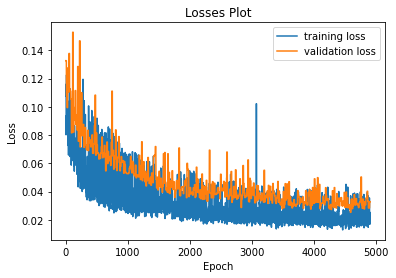

In [21]:
save_plots(args, losses, test_losses, disp_val_losses)

In [5]:
spt_data_list = []
spc_data_list = []
number_trajectories = 1
number_ts = 45

with open("data_test2.pkl",'rb') as file:
    data = pickle.load(file)

    for i, trajectory in enumerate(data.keys()):
        if(i==number_trajectories):
            break
        print("Trajectory: ",i)

        #We iterate over all the time steps to produce an example graph except
        #for the last one, which does not have a following time step to produce
        #node output values
        for ts in range(len(data[trajectory]['current_node_pos'])-1):

            if(ts==number_ts):
                break

            #Get node features
            ref_node_pos = torch.from_numpy(data[trajectory]['ref_node_pos'][ts])
            current_node_pos = torch.from_numpy(data[trajectory]['current_node_pos'][ts])
            del_ext_force = torch.from_numpy(data[trajectory]["del_ext_force"][ts])
            node_type_idx = data[trajectory]['node_types'][ts]
            # convert to one hot tensor form
            node_type = torch.zeros(node_type_idx.shape[0], np.unique(node_type_idx).shape[0])
            for j in range(node_type_idx.shape[0]):
                node_type[j, node_type_idx[j, 0]] = 1


            stress = torch.from_numpy(data[trajectory]['stress'][ts])
            stress = stress + (var_noise**0.5)*torch.randn(stress.shape)
            # x = torch.cat((ref_node_pos, current_node_pos, del_ext_force, node_type), dim=-1).type(torch.float)
            # x = node_type.type(torch.float)
            x = torch.cat((stress, node_type), dim=-1).type(torch.float)
            
            n_nodes = torch.tensor([[x.shape[0]]])

            edge_index = torch.from_numpy(data[trajectory]['edge_index'][ts]).type(torch.long)

            #Get edge features (mesh space as well as current configuration)
            uR_i = torch.from_numpy(data[trajectory]['ref_node_pos'][ts])[edge_index[0]]
            uR_j = torch.from_numpy(data[trajectory]['ref_node_pos'][ts])[edge_index[1]]
            uR_ij = uR_i-uR_j
            uR_ij_norm = torch.norm(uR_ij, p=2, dim=1, keepdim=True)
            uC_i = torch.from_numpy(data[trajectory]['current_node_pos'][ts])[edge_index[0]]
            uC_j = torch.from_numpy(data[trajectory]['current_node_pos'][ts])[edge_index[1]]
            uC_ij = uC_i-uC_j
            uC_ij_norm = torch.norm(uC_ij, p=2, dim=1, keepdim=True)

            edge_attr = torch.cat((uR_ij, uR_ij_norm), dim=-1).type(torch.float) #, uC_ij, uC_ij_norm

            del_ext_force = del_ext_force.type(torch.float)

            #Node outputs, for training
            del_displacement = torch.from_numpy(data[trajectory]['current_node_pos'][ts+1]-data[trajectory]['current_node_pos'][ts])
            # y = del_displacement.type(torch.float)
            stress_next = torch.from_numpy(data[trajectory]['stress'][ts+1])
            y = torch.cat((del_displacement, stress_next), dim=-1).type(torch.float)

            #Node outputs, for testing
            stress = torch.from_numpy(data[trajectory]['stress'][ts])
            strain_energy = torch.from_numpy(data[trajectory]['strain_energy'][ts])

            #Data needed for visualization code
            current_node_pos = torch.from_numpy(data[trajectory]['current_node_pos'][ts])

            # spectral graph information
            ed_idx, ed_w = get_laplacian(edge_index)
            lap = torch.sparse_coo_tensor(ed_idx, ed_w, (x.shape[0], x.shape[0]))
            lap = lap.to_dense()
            E, V = torch.linalg.eigh(lap)
            idx_st = 0
            E = E[idx_st:idx_st+num_eig]
            V = V[:, idx_st:idx_st+num_eig]
            V = V/torch.sqrt(torch.sum(V**2, axis=0))

            spx = E.reshape(-1, 1)
            sp_edge_index_init = torch.ones(num_eig, num_eig) - torch.eye(num_eig)
            sp_edge_index_init = sp_edge_index_init.to_sparse()
            sp_edge_index = sp_edge_index_init.indices()
            sp_edge_attr = torch.ones((sp_edge_index.shape[1], 1), dtype = torch.float)

            spt_data_list.append(Data(x = x, edge_index = edge_index, edge_attr = edge_attr, del_ext_force = del_ext_force, y = y,
                                  stress = stress, strain_energy = strain_energy, current_node_pos = current_node_pos))

            spc_data_list.append(Data(x = spx, edge_index = sp_edge_index, edge_attr = sp_edge_attr, V = V, n_nodes = n_nodes))

    

data_list = {"spt_data_list": spt_data_list, 
                "spc_data_list": spc_data_list}
            

print("data_list length: ", len(data_list))
print("Done collecting data!")

torch.save(data_list, 'processed_test_set.pt')
print("Done saving data!")

#os.path.join(data_folder + '/test.h5')
#torch.save(data_list,'./'+dataset_dir+'/test_processed_set.pt')

# print("Output Location: ", dataset_dir+'/test_processed_set.pt')

Trajectory:  0
data_list length:  2
Done collecting data!
Done saving data!


In [114]:
dataset = torch.load('processed_test_set.pt')
spt_dataset = dataset["spt_data_list"][:]
spc_dataset = dataset["spc_data_list"][:]

In [115]:
from matplotlib import animation
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def make_animation(gs, pred, evl, path, name , skip = 2, save_anim = True, plot_variables = False):
    '''
    input gs is a dataloader and each entry contains attributes of many timesteps.

    '''
    print('Generating displacement fields...')
    fig, axes = plt.subplots(2, 1, figsize=(20, 16))
    num_steps = len(gs) # for a single trajectory
    num_frames = num_steps // skip
    print(num_steps)
    def animate(num):
        step = (num*skip) % num_steps
        traj = 0

        bb_min = gs[-1].current_node_pos.min()
        bb_max = gs[-1].current_node_pos.max()
        bb_min_evl = evl[-1].current_node_pos.min()
        bb_max_evl = evl[-1].current_node_pos.max()
        count = 0

        for ax in axes:
            ax.cla()
            #ax.set_aspect('equal')
            #ax.set_axis_off()
            
            pos = gs[step].current_node_pos
            if (count == 0):
                # ground truth
                position_gs = gs[step].current_node_pos
                position_pred = pred[step].current_node_pos
                title = 'Ground truth and predicted current position'
                ax.plot(position_gs, torch.zeros(position_gs.shape), 'ko-', linewidth = 3.0)
                ax.plot(position_pred, torch.zeros(position_pred.shape), 'r*-', linewidth = 2.0)
                ax.set_xlim(bb_min, bb_max)
            else:
                position_gs = gs[step].current_node_pos
                position_err = evl[step].current_node_pos
                title = 'Error: (Prediction - Ground truth)'
                ax.plot(position_gs, position_err, 'ko-')
                ax.set_xlim(bb_min, bb_max)
                ax.set_ylim(-0.25, 0.25)
                ax.grid(True, axis = 'y')
            
            ax.set_title('{} Trajectory {} Step {}'.format(title, traj, step), fontsize = '20')
            
            count += 1
        return fig,

    # Save animation for visualization
    if not os.path.exists(path):
        os.makedirs(path)
    
    if (save_anim):
        gs_anim = animation.FuncAnimation(fig, animate, frames=num_frames, interval=1000)
        writergif = animation.PillowWriter(fps=2) 
        anim_path = os.path.join(path, '{}_anim.gif'.format(name))
        gs_anim.save( anim_path, writer=writergif)
        plt.show(block=True)
    else:
        pass

def visualize(loader, spc_dataset, best_model, file_dir, args, gif_name, stats_list, skip = 1):

    best_model.eval()
    device = args.device
    viz_data = {}
    gs_data = {}
    eval_data = {}
    viz_data_loader = copy.deepcopy(loader)
    gs_data_loader = copy.deepcopy(loader)
    eval_data_loader = copy.deepcopy(loader)
    [mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_force,std_vec_force,mean_vec_y,std_vec_y] = stats_list
    (mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_force,std_vec_force,mean_vec_y,std_vec_y)=(mean_vec_x.to(device),
            std_vec_x.to(device),mean_vec_edge.to(device),std_vec_edge.to(device),mean_vec_force.to(device),std_vec_force.to(device),
            mean_vec_y.to(device),std_vec_y.to(device))

    eval_data_loader[0].current_node_pos = 0.0*eval_data_loader[0].current_node_pos
    ref_node_pos = gs_data_loader[0].current_node_pos

    total_sq_error = torch.tensor([0])
    n_err = 0

    for idx, viz_data in enumerate(viz_data_loader[:-1]):
        
        gs_data_next = gs_data_loader[idx+1]
        viz_data_next = viz_data_loader[idx+1]
        eval_data_next = eval_data_loader[idx+1]

        viz_data = viz_data.to(args.device)
        spc_data = spc_dataset[idx].to(args.device)

        update_mask = torch.logical_or((torch.argmax(viz_data.x[:, 1:], dim=1) == torch.tensor(1)),
                                        (torch.argmax(viz_data.x[:, 1:], dim=1) == torch.tensor(2)))

        with torch.no_grad():
            pred = best_model(viz_data,spc_data,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_force,std_vec_force)
            # pred gives the learnt normalized displacement increament
            eval_disp = unnormalize(pred, mean_vec_y, std_vec_y)

            viz_data_next.current_node_pos[update_mask] = viz_data.current_node_pos[update_mask] + eval_disp[update_mask]
            pred_disp = viz_data_next.current_node_pos - ref_node_pos
            disp = gs_data_next.current_node_pos - ref_node_pos
            error_disp = torch.abs(pred_disp - disp)/torch.abs(disp)
            eval_data_next.current_node_pos[update_mask] = error_disp[update_mask]
            total_sq_error = total_sq_error + torch.sum(eval_data_next.current_node_pos**2)
            n_err = n_err + error_disp.shape[0]

            uC_i = viz_data_next.current_node_pos[viz_data_next.edge_index[0]]
            uC_j = viz_data_next.current_node_pos[viz_data_next.edge_index[1]]
            uC_ij = uC_i-uC_j
            uC_ij_norm = torch.norm(uC_ij, p=2, dim=1, keepdim=True)

            #viz_data_next.edge_attr[:, 2:] = torch.cat((uC_ij, uC_ij_norm), dim=-1)
    
    total_error = torch.sqrt(total_sq_error/n_err)
    print('Total error in prediction: ', total_error)
    #print(viz_data_loader)
    make_animation(gs_data_loader, viz_data_loader, eval_data_loader, file_dir,
                      gif_name, skip, True, False)

    return eval_data_loader

In [116]:
# load model. 
args.device = torch.device('cpu') # animation function cannot work with data on GPU
num_node_features = spt_dataset[0].x.shape[1]
num_edge_features = spt_dataset[0].edge_attr.shape[1]
num_sp_node_features = spc_dataset[0].x.shape[1]
num_sp_edge_features = spc_dataset[0].edge_attr.shape[1]
num_ext_force = spt_dataset[0].del_ext_force.shape[1]
num_classes = 1 # the dynamic variables have the shape of 2 (velocity)
#model_name = 'model_nl10_bs32_hd16_ep10000_wd0.0005_lr0.001_shuff_True_tr448_te64'
model_name='model_spectralGNN_w_X_StressType_nl'+str(args.num_layers)+'_bs'+str(args.batch_size) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.epochs)+'_wd'+str(args.weight_decay) + \
               '_lr'+str(args.lr)+'_shuff_'+str(args.shuffle)+'_tr'+str(args.train_size)+'_te'+str(args.test_size)
PATH = os.path.join(args.checkpoint_dir, model_name+'.pt')
model = MeshGraphNet(num_node_features, num_edge_features, num_sp_node_features, num_sp_edge_features, 
                            args.hidden_dim, num_ext_force, num_classes, args).to(device)

model.load_state_dict(torch.load(PATH, map_location=args.device))

<All keys matched successfully>

In [117]:
spc_dataset

[Data(x=[3, 1], edge_index=[2, 6], edge_attr=[6, 1], V=[12, 3], n_nodes=[1, 1]),
 Data(x=[3, 1], edge_index=[2, 6], edge_attr=[6, 1], V=[12, 3], n_nodes=[1, 1]),
 Data(x=[3, 1], edge_index=[2, 6], edge_attr=[6, 1], V=[12, 3], n_nodes=[1, 1]),
 Data(x=[3, 1], edge_index=[2, 6], edge_attr=[6, 1], V=[12, 3], n_nodes=[1, 1]),
 Data(x=[3, 1], edge_index=[2, 6], edge_attr=[6, 1], V=[12, 3], n_nodes=[1, 1]),
 Data(x=[3, 1], edge_index=[2, 6], edge_attr=[6, 1], V=[12, 3], n_nodes=[1, 1]),
 Data(x=[3, 1], edge_index=[2, 6], edge_attr=[6, 1], V=[12, 3], n_nodes=[1, 1]),
 Data(x=[3, 1], edge_index=[2, 6], edge_attr=[6, 1], V=[12, 3], n_nodes=[1, 1]),
 Data(x=[3, 1], edge_index=[2, 6], edge_attr=[6, 1], V=[12, 3], n_nodes=[1, 1]),
 Data(x=[3, 1], edge_index=[2, 6], edge_attr=[6, 1], V=[12, 3], n_nodes=[1, 1]),
 Data(x=[3, 1], edge_index=[2, 6], edge_attr=[6, 1], V=[12, 3], n_nodes=[1, 1]),
 Data(x=[3, 1], edge_index=[2, 6], edge_attr=[6, 1], V=[12, 3], n_nodes=[1, 1]),
 Data(x=[3, 1], edge_index=[

Total error in prediction:  tensor([0.0642], dtype=torch.float64)
Generating displacement fields...
45


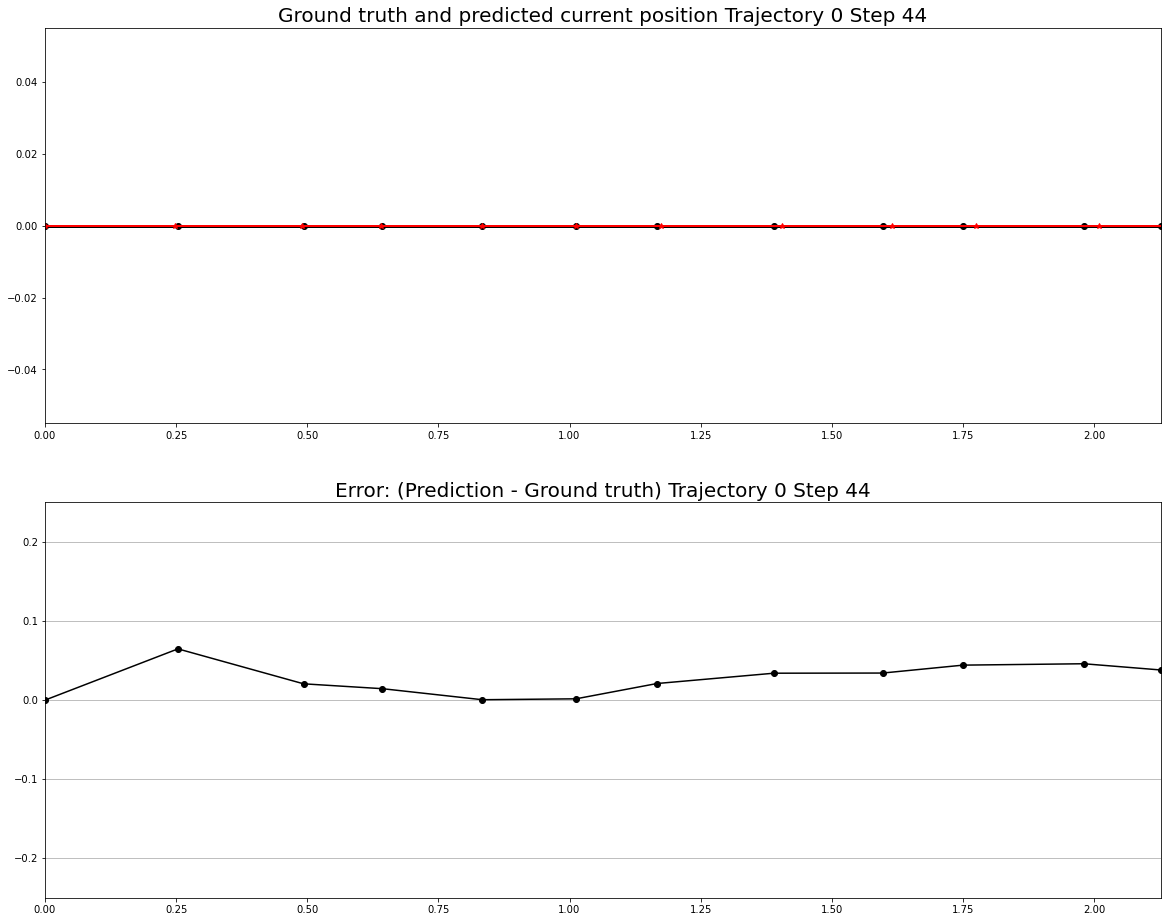

In [118]:
# visualize predicted displacement
dataset_vis = spt_dataset
animation_name = model_name+'_current position'
args.postprocess_dir = './postprocess_dir/'
if not os.path.isdir(args.postprocess_dir):
        os.mkdir(args.postprocess_dir)

eval_data_loader = visualize(dataset_vis, spc_dataset, model, args.postprocess_dir, args, animation_name, stats_list, skip = 1)

In [ ]:
viz_data_loader = copy.deepcopy(dataset_vis)
viz_data_next = viz_data_loader[-1]
viz_data_next.current_node_pos[-1] = 100.0

In [ ]:
print(viz_data_next.current_node_pos[-1], viz_data_loader[-1].current_node_pos[-1])

tensor([100.], dtype=torch.float64) tensor([100.], dtype=torch.float64)
